# CASO PRÁCTICO SOBRE ANÁLISIS ESTADÍSTICO
## CONTRASTES DE HIPÓTESIS, FACETAS DESCRIPTIVAS Y PROMPTING

El presente caso práctico pretende cubrir los siguientes puntos, por medio de las librerías Matplotlib, SciPy, NumPy y la API de OpenAI:

- Generación de muestras aleatorias
- Contrastes paramétricos sobre muestras emparejadas
- Contrastes no paramétricos
- Generación de gráficas
- Elaboración de prompts y regulación de la creatividad generativa

In [77]:
#!pip install openai

In [2]:
from openai import OpenAI
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import numpy as np

Una vez que se importan las librerías y módulos necesarios, se definen las instancias y funciones que necesitaremos a la hora de lanzar prompts desde el notebook:

In [74]:
#os.environ['OPENAI_API_KEY'] = '{ESCRIBIR UNA CLAVE DE AUTENTICACIÓN API}' -> https://platform.openai.com/api-keys

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def raiseQuestion_Prompting(prompt, temp):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "user", "content": prompt}
      ],
      temperature=temp
    )
    return completion.choices[0].message

## CÁLCULO DE ESTADÍSTICOS

Se generarán dos muestras aleatorio. El contexto propuesto serán **los precios de una serie de viviendas (muestra aleatoria) tanto antes como después** de aplicar una política concreta con ciertas **repercusiones en el mercado inmobiliario de la urbe**.

In [4]:
precios_muestra_1 = np.random.randint(350000, 450001, size=30)
precios_muestra_2 = np.random.randint(300000, 380001, size=30)

dataset_completo = np.vstack([precios_muestra_1, precios_muestra_2])

Se calculará un contraste de hipótesis para dos muestras emparejadas.

Para ello, se aplicará el t-test, que guarda relación con **la distribución t-Student**, derivada de la distribución normal. Hay una mayor robustez a la no normalidad y, aparte de tener muestras no muy grandes, **desconocemos la varianza poblacional**.

Precisamente, se quiere contrastar si las políticas aplicadas han resultado en **un descenso de los precios**. Por ello, se aplicará **un contraste de hipótesis de cola derecha**. 

La hipótesis alternativa sugeriría **una diferencia positiva entre los promedios previo y posterior a la política aplicada**.

In [5]:
res1 = sci.stats.ttest_rel(dataset_completo[0], dataset_completo[1], axis=0, alternative='greater')

In [6]:
print(res1)

TtestResult(statistic=9.091722694023439, pvalue=2.733791831725714e-10, df=29)


En caso de querer contrastar que no ha habido descenso, habrá que aplicar **un contraste de cola izquierda** (la hipótesis alternativa sugeriría **una diferencia negativa entre los promedios previo y posterior a la política aplicada**).

In [7]:
res2 = sci.stats.ttest_rel(dataset_completo[0], dataset_completo[1], axis=0, alternative='less')

In [8]:
print(res2)

TtestResult(statistic=9.091722694023439, pvalue=0.9999999997266208, df=29)


Si se contrastase que **hubiera una diferencia sin más**, habría que aplicar **un contraste bilateral** (la hipótesis alternativa nos sugeriría **una mera diferencia** entre promedios).

In [22]:
res3 = sci.stats.ttest_rel(dataset_completo[0], dataset_completo[1], axis=0, alternative='two-sided')

In [23]:
print(res3)

TtestResult(statistic=9.091722694023439, pvalue=5.467583663451428e-10, df=29)


Detectamos ahora **los intervalos de confianza en cada escenario, con niveles de significación del 5%**.

In [11]:
print(res1.confidence_interval(confidence_level=0.95))
print(res2.confidence_interval(confidence_level=0.95))
print(res3.confidence_interval(confidence_level=0.95))

ConfidenceInterval(low=51209.461719129955, high=inf)
ConfidenceInterval(low=-inf, high=74749.60494753672)
ConfidenceInterval(low=-inf, high=74749.60494753672)


Generamos unos **histogramas de frecuencias**, con una curva gaussiana.

Primero trabajaremos con la muestra pre-política y después con la muestra post-política. 

En cada caso, se calculará también un contraste no paramétrico que permita verificar si cada muestra proviene de **una distribución normal**. Se empleará **el test de Shapiro-Wilk**.

Media: 402269, Desviación estándar: 30686, CV:  7%


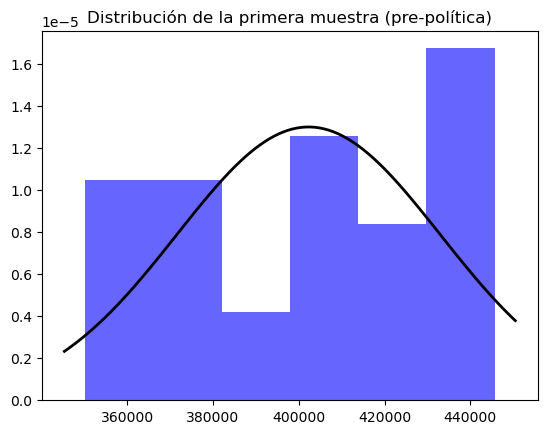

In [12]:
mean = dataset_completo[0].mean()
std = dataset_completo[0].std()
cv = std/mean * 100
print("Media: %2d, Desviación estándar: %2d, CV: %2d%%" % (mean, std, cv)) 
plt.hist(dataset_completo[0], bins='auto', density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = sci.stats.norm.pdf(x, mean, std)
 
plt.plot(x, p, 'k', linewidth=2)
title = "Distribución de la primera muestra (pre-política)"
plt.title(title)
 
plt.show()

In [13]:
sci.stats.shapiro(dataset_completo[0])

ShapiroResult(statistic=0.9233753681182861, pvalue=0.032841261476278305)

Media: 339289, Desviación estándar: 24320, CV:  7%


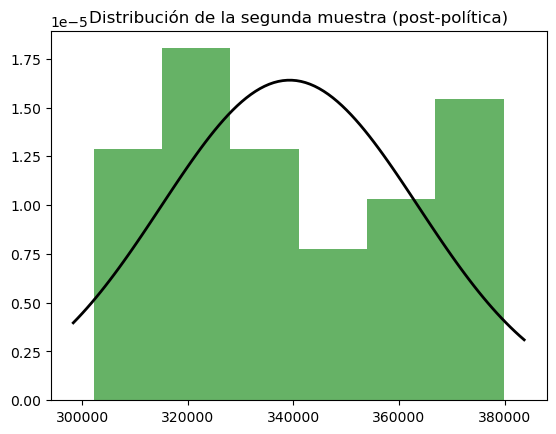

In [14]:
mean = dataset_completo[1].mean()
std = dataset_completo[1].std()
cv = std/mean * 100
print("Media: %2d, Desviación estándar: %2d, CV: %2d%%" % (mean, std, cv)) 
plt.hist(dataset_completo[1], bins='auto', density=True, alpha=0.6, color='green')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = sci.stats.norm.pdf(x, mean, std)
 
plt.plot(x, p, 'k', linewidth=2)
title = "Distribución de la segunda muestra (post-política)"
plt.title(title)
 
plt.show()

In [15]:
sci.stats.shapiro(dataset_completo[1])

ShapiroResult(statistic=0.92477947473526, pvalue=0.0357457660138607)

## REPORTING GENERATIVO

En este apartado, se elaborarán varios prompts que nos permitan interactuar con la versión 3.5 Turbo de **GPT**, el modelo en el que se marca el "popular" **ChatGPT**.

Se utilizarán distintos valores de **temperatura**, en base a los cuales regularemos **la creatividad** de las respuestas (reduciendo, en un orden inversamente proporcional, la acotación determinista de las respuestas generadas).

### TEMPERATURA 0

In [16]:
prompt = ("Tenemos dos muestras relacionadas sobre el precio de la vivienda (30 elementos cada una). "
          + "La primera tiene una media de " 
          + str(dataset_completo[0].mean()) + " y la segunda, de " + str(dataset_completo[1].mean()) + ". "
          + "Si contrastamos que se ha dado un efecto que resulte en que la segunda tenga valores más bajos en promedio, "
          + "¿qué podríamos verificar con un contraste de cola derecha? Habríamos obtenido, con una prueba de t-test, un "
          + "p-valor de " + str(res1.pvalue) + ". Consideramos un nivel de significación del 5%.")
prompt

'Tenemos dos muestras relacionadas sobre el precio de la vivienda (30 elementos cada una). La primera tiene una media de 402269.0 y la segunda, de 339289.4666666667. Si contrastamos que se ha dado un efecto que resulte en que la segunda tenga valores más bajos en promedio, ¿qué podríamos verificar con un contraste de cola derecha? Habríamos obtenido, con una prueba de t-test, un p-valor de 2.733791831725714e-10. Consideramos un nivel de significación del 5%.'

In [17]:
raiseQuestion_Prompting(prompt, 0).content

'Con un contraste de cola derecha y un nivel de significación del 5%, podríamos verificar si la media de la segunda muestra es significativamente menor que la media de la primera muestra. Dado que el p-valor obtenido es menor que el nivel de significación (2.733791831725714e-10 < 0.05), podemos concluir que hay evidencia estadística para rechazar la hipótesis nula de que las medias son iguales y afirmar que la segunda muestra tiene valores más bajos en promedio que la primera muestra.'

In [26]:
prompt = ("Si contrastásemos, para esas mismas muestras, un escenario de bilateralidad, obtenemos un p-valor de " + str(res3.pvalue) + ". "
         + "Tendríamos el mismo nivel de significación que antes. Quizá se cumpla la hipótesis alternativa. Ahora bien, de ser así, "
         + "¿Sería complementario este contraste? ¿Basta con aplicar el de cola derecha, de cara a lo que queremos verificar (bajada de precios)?")
prompt

'Si contrastásemos, para esas mismas muestras, un escenario de bilateralidad, obtenemos un p-valor de 5.467583663451428e-10. Tendríamos el mismo nivel de significación que antes. Quizá se cumpla la hipótesis alternativa. Ahora bien, de ser así, ¿Sería complementario este contraste? ¿Basta con aplicar el de cola derecha, de cara a lo que queremos verificar (bajada de precios)?'

In [27]:
raiseQuestion_Prompting(prompt, 0).content

'En este caso, al obtener un p-valor muy bajo en el contraste de bilateralidad, podemos concluir que existe una diferencia significativa en los precios entre las dos muestras. Sin embargo, es importante tener en cuenta que el contraste de bilateralidad no nos indica en qué dirección se encuentra esa diferencia, es decir, no nos dice si los precios han bajado o subido.\n\nPara determinar si los precios han bajado, en este caso específico, sería necesario realizar un contraste de cola derecha, ya que estamos interesados en verificar si hay una disminución en los precios. Si al aplicar este contraste obtenemos un p-valor significativo, podríamos concluir que los precios han bajado de manera significativa en las muestras analizadas.\n\nEn resumen, el contraste de cola derecha sería complementario al contraste de bilateralidad en este caso, ya que nos permitiría verificar específicamente si ha habido una bajada de precios, en lugar de simplemente detectar una diferencia significativa en los

In [34]:
prompt = ("En el caso de asumir definitiva y exclusivamente el contraste de cola derecha, tendríamos, para un nivel de confianza del 95% "
         + " un intervalo de confianza tal como " + str(res1.confidence_interval(confidence_level=0.95)) + ". ¿Qué conclusiones interpretativas deberíamos de hacer?")
prompt

'En el caso de asumir definitiva y exclusivamente el contraste de cola derecha, tendríamos, para un nivel de confianza del 95%  un intervalo de confianza tal como ConfidenceInterval(low=51209.461719129955, high=inf). ¿Qué conclusiones interpretativas deberíamos de hacer?'

In [35]:
raiseQuestion_Prompting(prompt, 0).content

'Si asumimos definitiva y exclusivamente el contraste de cola derecha, podemos concluir que con un nivel de confianza del 95%, el valor verdadero de la población se encuentra por encima de 51209.461719129955. Esto significa que podemos afirmar con un 95% de confianza que la media poblacional es mayor que este valor.'

In [46]:
prompt = ("¿Se refiere el intervalo de confianza de un contraste de muestras pareadas a la diferencia de medias?"
          + " Asumiríamos que como mínimo la diferencia está en torno a 51209 (el contraste es unilateral de cola derecha)")
prompt

'¿Se refiere el intervalo de confianza de un contraste de muestras pareadas a la diferencia de medias? Asumiríamos que como mínimo la diferencia está en torno a 51209 (el contraste es unilateral de cola derecha)'

In [47]:
raiseQuestion_Prompting(prompt, 0).content

'Sí, el intervalo de confianza de un contraste de muestras pareadas se refiere a la diferencia de medias entre las dos muestras. En este caso, si el contraste es unilateral de cola derecha y asumimos que la diferencia mínima está en torno a 51209, entonces el intervalo de confianza nos permitirá estimar con cierta certeza que la verdadera diferencia de medias se encuentra por encima de ese valor.'

In [54]:
prompt = ("Se ha generado, para cada una de las muestras, un histograma de frecuencias. Ninguno de ambos sigue la línea de la campana gaussiana. "
         + "Pero para verificarlo mejor, se ha hecho una prueba de Shapiro-Wilk. En ambos casos obtenemos un p-valor que dista dos centésimas (por debajo) "
         + "del nivel de significación del 5%. ¿En qué medida podemos negar que ambas muestras provienen de una distribución normal? "
         + "¿Hay alguna implicación de cara al emparejamiento previamente considerado entre ambas muestras?")
prompt

'Se ha generado, para cada una de las muestras, un histograma de frecuencias. Ninguno de ambos sigue la línea de la campana gaussiana. Pero para verificarlo mejor, se ha hecho una prueba de Shapiro-Wilk. En ambos casos obtenemos un p-valor que dista dos centésimas (por debajo) del nivel de significación del 5%. ¿En qué medida podemos negar que ambas muestras provienen de una distribución normal? ¿Hay alguna implicación de cara al emparejamiento previamente considerado entre ambas muestras?'

In [55]:
raiseQuestion_Prompting(prompt, 0).content

'Dado que el p-valor obtenido en la prueba de Shapiro-Wilk está por debajo del nivel de significación del 5%, podemos rechazar la hipótesis nula de que las muestras provienen de una distribución normal. Esto sugiere que las muestras no siguen una distribución normal.\n\nEn cuanto al emparejamiento previamente considerado entre ambas muestras, esta información puede tener implicaciones. Si se estaba asumiendo que las muestras seguían una distribución normal para realizar ciertos análisis estadísticos, es posible que estos análisis no sean válidos. En este caso, se debería considerar utilizar métodos estadísticos no paramétricos que no requieran la suposición de normalidad en los datos.'

### TEMPERATURA 0.5

In [18]:
prompt = ("Tenemos dos muestras relacionadas sobre el precio de la vivienda (30 elementos cada una). "
          + "La primera tiene una media de " 
          + str(dataset_completo[0].mean()) + " y la segunda, de " + str(dataset_completo[1].mean()) + ". "
          + "Si contrastamos que se ha dado un efecto que resulte en que la segunda tenga valores más bajos en promedio, "
          + "¿qué podríamos verificar con un contraste de cola derecha? Habríamos obtenido, con una prueba de t-test, un "
          + "p-valor de " + str(res1.pvalue) + ". Consideramos un nivel de significación del 5%.")
prompt

'Tenemos dos muestras relacionadas sobre el precio de la vivienda (30 elementos cada una). La primera tiene una media de 402269.0 y la segunda, de 339289.4666666667. Si contrastamos que se ha dado un efecto que resulte en que la segunda tenga valores más bajos en promedio, ¿qué podríamos verificar con un contraste de cola derecha? Habríamos obtenido, con una prueba de t-test, un p-valor de 2.733791831725714e-10. Consideramos un nivel de significación del 5%.'

In [19]:
raiseQuestion_Prompting(prompt, 0.5).content

'Con un contraste de cola derecha y un p-valor tan bajo (2.733791831725714e-10), podemos concluir que hay evidencia suficiente para rechazar la hipótesis nula de que las medias de ambas muestras son iguales. En este caso, podemos afirmar que la segunda muestra tiene valores más bajos en promedio que la primera muestra, con un nivel de significación del 5%.'

In [28]:
prompt = ("Si contrastásemos, para esas mismas muestras, un escenario de bilateralidad, obtenemos un p-valor de " + str(res3.pvalue) + ". "
         + "Tendríamos el mismo nivel de significación que antes. Quizá se cumpla la hipótesis alternativa. Ahora bien, de ser así, "
         + "¿Sería complementario este contraste? ¿Basta con aplicar el de cola derecha, de cara a lo que queremos verificar (bajada de precios)?")
prompt

'Si contrastásemos, para esas mismas muestras, un escenario de bilateralidad, obtenemos un p-valor de 5.467583663451428e-10. Tendríamos el mismo nivel de significación que antes. Quizá se cumpla la hipótesis alternativa. Ahora bien, de ser así, ¿Sería complementario este contraste? ¿Basta con aplicar el de cola derecha, de cara a lo que queremos verificar (bajada de precios)?'

In [29]:
raiseQuestion_Prompting(prompt, 0.5).content

'En este caso, al obtener un p-valor tan bajo en el contraste de bilateralidad, podemos afirmar con un alto nivel de confianza que existe una diferencia significativa entre las muestras en términos de la variable que estamos analizando (bajada de precios). \n\nEn cuanto a si sería complementario este contraste, la respuesta dependerá de la naturaleza de la hipótesis alternativa que estamos evaluando. Si la hipótesis alternativa está formulada en términos de una dirección específica (por ejemplo, una bajada de precios), entonces sería más apropiado utilizar un contraste de cola derecha para evaluar si esta dirección se cumple. \n\nEn resumen, en este caso específico, dado el p-valor obtenido en el contraste de bilateralidad y la naturaleza de la hipótesis alternativa, sería adecuado utilizar un contraste de cola derecha para verificar si se cumple la hipótesis de bajada de precios.'

In [36]:
prompt = ("En el caso de asumir definitiva y exclusivamente el contraste de cola derecha, tendríamos, para un nivel de confianza del 95% "
         + " un intervalo de confianza tal como " + str(res1.confidence_interval(confidence_level=0.95)) + ". ¿Qué conclusiones interpretativas deberíamos de hacer?")
prompt

'En el caso de asumir definitiva y exclusivamente el contraste de cola derecha, tendríamos, para un nivel de confianza del 95%  un intervalo de confianza tal como ConfidenceInterval(low=51209.461719129955, high=inf). ¿Qué conclusiones interpretativas deberíamos de hacer?'

In [37]:
raiseQuestion_Prompting(prompt, 0.5).content

'En este caso, al asumir que el contraste de cola derecha es el único en consideración, podemos concluir que existe una alta probabilidad de que el verdadero valor de la población sea mayor o igual a 51209.46 con un nivel de confianza del 95%. Esto significa que, en base a nuestra muestra y considerando el margen de error, podemos afirmar con un 95% de confianza que el verdadero valor de la población es al menos igual a 51209.46.'

In [48]:
prompt = ("¿Se refiere el intervalo de confianza de un contraste de muestras pareadas a la diferencia de medias?"
          + " Asumiríamos que como mínimo la diferencia está en torno a 51209 (el contraste es unilateral de cola derecha)")
prompt

'¿Se refiere el intervalo de confianza de un contraste de muestras pareadas a la diferencia de medias? Asumiríamos que como mínimo la diferencia está en torno a 51209 (el contraste es unilateral de cola derecha)'

In [49]:
raiseQuestion_Prompting(prompt, 0.5).content

'Sí, el intervalo de confianza de un contraste de muestras pareadas se refiere a la diferencia de medias entre las dos muestras. En este caso, si el contraste es unilateral de cola derecha y asumimos que la diferencia mínima está en torno a 51209, entonces el intervalo de confianza nos permitirá determinar con cierta probabilidad si la diferencia real entre las medias es mayor a 51209.'

In [56]:
prompt = ("Se ha generado, para cada una de las muestras, un histograma de frecuencias. Ninguno de ambos sigue la línea de la campana gaussiana. "
         + "Pero para verificarlo mejor, se ha hecho una prueba de Shapiro-Wilk. En ambos casos obtenemos un p-valor que dista dos centésimas (por debajo) "
         + "del nivel de significación del 5%. ¿En qué medida podemos negar que ambas muestras provienen de una distribución normal? "
         + "¿Hay alguna implicación de cara al emparejamiento previamente considerado entre ambas muestras?")
prompt

'Se ha generado, para cada una de las muestras, un histograma de frecuencias. Ninguno de ambos sigue la línea de la campana gaussiana. Pero para verificarlo mejor, se ha hecho una prueba de Shapiro-Wilk. En ambos casos obtenemos un p-valor que dista dos centésimas (por debajo) del nivel de significación del 5%. ¿En qué medida podemos negar que ambas muestras provienen de una distribución normal? ¿Hay alguna implicación de cara al emparejamiento previamente considerado entre ambas muestras?'

In [57]:
raiseQuestion_Prompting(prompt, 0.5).content

'Dado que el p-valor obtenido en la prueba de Shapiro-Wilk está por debajo del nivel de significación del 5%, podemos rechazar la hipótesis nula de que las muestras provienen de una distribución normal. Esto sugiere que las muestras no siguen una distribución normal.\n\nEn cuanto al emparejamiento previamente considerado entre ambas muestras, esto podría implicar que los supuestos de normalidad no se cumplen, lo cual puede afectar la validez de ciertos análisis estadísticos que se basan en la normalidad de los datos, como por ejemplo pruebas paramétricas. En este caso, sería recomendable considerar métodos no paramétricos para el análisis de las muestras.'

### TEMPERATURA 1

In [20]:
prompt = ("Tenemos dos muestras relacionadas sobre el precio de la vivienda (30 elementos cada una). "
          + "La primera tiene una media de " 
          + str(dataset_completo[0].mean()) + " y la segunda, de " + str(dataset_completo[1].mean()) + ". "
          + "Si contrastamos que se ha dado un efecto que resulte en que la segunda tenga valores más bajos en promedio, "
          + "¿qué podríamos verificar con un contraste de cola derecha? Habríamos obtenido, con una prueba de t-test, un "
          + "p-valor de " + str(res1.pvalue) + ". Consideramos un nivel de significación del 5%.")
prompt

'Tenemos dos muestras relacionadas sobre el precio de la vivienda (30 elementos cada una). La primera tiene una media de 402269.0 y la segunda, de 339289.4666666667. Si contrastamos que se ha dado un efecto que resulte en que la segunda tenga valores más bajos en promedio, ¿qué podríamos verificar con un contraste de cola derecha? Habríamos obtenido, con una prueba de t-test, un p-valor de 2.733791831725714e-10. Consideramos un nivel de significación del 5%.'

In [21]:
raiseQuestion_Prompting(prompt, 1).content

'Con un contraste de cola derecha con un nivel de significación del 5%, podríamos verificar si la media de la segunda muestra es significativamente menor que la media de la primera muestra. Dado que el p-valor obtenido es menor que el nivel de significación (2.733791831725714e-10 < 0.05), rechazaríamos la hipótesis nula de que no hay diferencia en los precios de las viviendas entre ambas muestras. Esto nos llevaría a concluir que, efectivamente, ha habido un efecto que ha provocado que los precios en la segunda muestra sean más bajos en promedio que en la primera muestra.'

In [30]:
prompt = ("Si contrastásemos, para esas mismas muestras, un escenario de bilateralidad, obtenemos un p-valor de " + str(res3.pvalue) + ". "
         + "Tendríamos el mismo nivel de significación que antes. Quizá se cumpla la hipótesis alternativa. Ahora bien, de ser así, "
         + "¿Sería complementario este contraste? ¿Basta con aplicar el de cola derecha, de cara a lo que queremos verificar (bajada de precios)?")
prompt

'Si contrastásemos, para esas mismas muestras, un escenario de bilateralidad, obtenemos un p-valor de 5.467583663451428e-10. Tendríamos el mismo nivel de significación que antes. Quizá se cumpla la hipótesis alternativa. Ahora bien, de ser así, ¿Sería complementario este contraste? ¿Basta con aplicar el de cola derecha, de cara a lo que queremos verificar (bajada de precios)?'

In [31]:
raiseQuestion_Prompting(prompt, 1).content

'En este caso, al obtener un p-valor muy bajo en el escenario de bilateralidad, se sigue teniendo un nivel significativo de evidencia para rechazar la hipótesis nula. Sin embargo, la interpretación de los resultados podría variar ligeramente.\n\nEn el caso de un contraste de una cola, se estaría comprobando si hay evidencia suficiente para afirmar que los precios han bajado. Mientras que en el caso de un contraste de dos colas, se estaría comprobando si hay evidencia suficiente para afirmar que los precios han disminuido o aumentado.\n\nEn este contexto, si se cumple la hipótesis alternativa y se confirma que los precios han bajado, se podría interpretar como un resultado complementario en ambos casos. Sin embargo, es importante considerar la dirección de la hipótesis alternativa y seleccionar el tipo de contraste adecuado de acuerdo al objetivo de la investigación y la pregunta que se quiere responder.'

In [38]:
prompt = ("En el caso de asumir definitiva y exclusivamente el contraste de cola derecha, tendríamos, para un nivel de confianza del 95% "
         + " un intervalo de confianza tal como " + str(res1.confidence_interval(confidence_level=0.95)) + ". ¿Qué conclusiones interpretativas deberíamos de hacer?")
prompt

'En el caso de asumir definitiva y exclusivamente el contraste de cola derecha, tendríamos, para un nivel de confianza del 95%  un intervalo de confianza tal como ConfidenceInterval(low=51209.461719129955, high=inf). ¿Qué conclusiones interpretativas deberíamos de hacer?'

In [39]:
raiseQuestion_Prompting(prompt, 1).content

'Si asumimos definitiva y exclusivamente el contraste de cola derecha con un nivel de confianza del 95%, significa que estamos seguros al 95% de que el valor verdadero de la variable de interés está por encima del límite superior del intervalo de confianza dado, que en este caso es infinito. \n\nEsto podría interpretarse como que existe una alta probabilidad de que el valor de la variable esté significativamente por encima del límite superior establecido, lo cual puede ser indicativo de un resultado positivo, una maximización o un incremento en la métrica considerada. Sin embargo, al tener un límite superior infinito, la precisión de esta conclusión se ve afectada y podría necesitar de un ajuste para ser más específica y útil en la toma de decisiones.'

In [50]:
prompt = ("¿Se refiere el intervalo de confianza de un contraste de muestras pareadas a la diferencia de medias?"
          + " Asumiríamos que como mínimo la diferencia está en torno a 51209 (el contraste es unilateral de cola derecha)")
prompt

'¿Se refiere el intervalo de confianza de un contraste de muestras pareadas a la diferencia de medias? Asumiríamos que como mínimo la diferencia está en torno a 51209 (el contraste es unilateral de cola derecha)'

In [51]:
raiseQuestion_Prompting(prompt, 1).content

'Sí, el intervalo de confianza de un contraste de muestras pareadas se refiere a la diferencia de medias entre las dos muestras. En este caso, si el contraste es unilateral de cola derecha y asumimos que la diferencia de medias es como mínimo 51209, se estaría considerando que la diferencia de medias es mayor o igual a este valor. El intervalo de confianza nos daría una estimación de la precisión de esta diferencia de medias y nos permitiría determinar si el valor de 51209 está dentro de este intervalo con cierto nivel de confianza.'

In [58]:
prompt = ("Se ha generado, para cada una de las muestras, un histograma de frecuencias. Ninguno de ambos sigue la línea de la campana gaussiana. "
         + "Pero para verificarlo mejor, se ha hecho una prueba de Shapiro-Wilk. En ambos casos obtenemos un p-valor que dista dos centésimas (por debajo) "
         + "del nivel de significación del 5%. ¿En qué medida podemos negar que ambas muestras provienen de una distribución normal? "
         + "¿Hay alguna implicación de cara al emparejamiento previamente considerado entre ambas muestras?")
prompt

'Se ha generado, para cada una de las muestras, un histograma de frecuencias. Ninguno de ambos sigue la línea de la campana gaussiana. Pero para verificarlo mejor, se ha hecho una prueba de Shapiro-Wilk. En ambos casos obtenemos un p-valor que dista dos centésimas (por debajo) del nivel de significación del 5%. ¿En qué medida podemos negar que ambas muestras provienen de una distribución normal? ¿Hay alguna implicación de cara al emparejamiento previamente considerado entre ambas muestras?'

In [59]:
raiseQuestion_Prompting(prompt, 1).content

'Dado que el p-valor obtenido en la prueba de Shapiro-Wilk es ligeramente inferior al nivel de significación del 5%, podemos afirmar que hay evidencia suficiente para rechazar la hipótesis nula de que las muestras provienen de una distribución normal. Esto indica que las muestras no siguen un patrón de distribución gaussiana.\n\nEn cuanto al emparejamiento previamente considerado entre ambas muestras, esta falta de normalidad en los datos puede tener implicaciones en los análisis estadísticos que se realicen posteriormente. Es importante tener en cuenta que muchos métodos estadísticos asumen la normalidad de los datos, por lo que es posible que los resultados obtenidos no sean del todo válidos si las muestras no siguen una distribución normal. En este caso, será necesario considerar métodos alternativos que sean más apropiados para datos no gaussianos.'

In [60]:
prompt = ("Si ninguna de las muestras proviene de una distribución normal, "
          + "¿cómo deberíamos de interpretar los resultados del contraste de cola derecha para muestras emparejadas? " 
          + "Hablamos de los mismos elementos, antes y después de unas políticas concretas (tiempos distintos)")
prompt

'Si ninguna de las muestras proviene de una distribución normal, ¿cómo deberíamos de interpretar los resultados del contraste de cola derecha para muestras emparejadas? Hablamos de los mismos elementos, antes y después de unas políticas concretas (tiempos distintos)'

In [61]:
raiseQuestion_Prompting(prompt, 1).content

'En este caso, si ninguna de las muestras proviene de una distribución normal, la interpretación de los resultados del contraste de cola derecha para muestras emparejadas se verá afectada. Las pruebas estadísticas paramétricas, como el contraste de cola derecha para muestras emparejadas, asumen que los datos siguen una distribución normal.\n\nSi las muestras no siguen una distribución normal, se recomienda utilizar pruebas estadísticas no paramétricas, como la prueba de Wilcoxon para muestras emparejadas. Esta prueba es una alternativa robusta que no requiere que los datos sigan una distribución normal.\n\nPor lo tanto, si ninguna de las muestras proviene de una distribución normal, es importante realizar un análisis no paramétrico y considerar los resultados de manera más conservadora, ya que los supuestos de las pruebas paramétricas no se cumplen.'

### OBSERVACIONES

Se puede observar que, a medida que aumentamos la temperatura, **más extensas y elaboradas son las respuestas**.

En este caso, en el rango considerado, no se ha detectado **ninguna alucinación considerable**. Más bien, hemos de prestar atención a la sugerencia, **con temperatura 1**, en relación **al empleo de la prueba de Wilcoxon** al no cumplirse los supuestos de normalidad.

Efectivamente, **se trata de una prueba no paramétrica** que es **alternativa a la prueba de t-Student**, al no poder asumir **la normalidad de las muestras**. A continuación, se aplicará la misma (en escenarios de bilateralidad y unilateralidad, respectivamente).

#### CÁLCULO DE LA PRUEBA DE WILCOXON

In [64]:
res_bil = sci.stats.wilcoxon(dataset_completo[0], dataset_completo[1], axis=0, alternative='two-sided')
print(res_bil)

WilcoxonResult(statistic=1.0, pvalue=3.725290298461914e-09)


In [66]:
res_uizq = sci.stats.wilcoxon(dataset_completo[0], dataset_completo[1], axis=0, alternative='less')
print(res_uizq)

WilcoxonResult(statistic=464.0, pvalue=0.9999999990686774)


In [65]:
res_uder = sci.stats.wilcoxon(dataset_completo[0], dataset_completo[1], axis=0, alternative='greater')
print(res_uder)

WilcoxonResult(statistic=464.0, pvalue=1.862645149230957e-09)


#### RETORNO AL REPORTING GENERATIVO

Se generarán respuestas con cada uno de los valores de temperatura propuestos antes:

In [69]:
prompt = ("Sobre estas mismas muestras, hemos aplicado la prueba de Wilcoxon. Los contrastes de unilateralidad de cola derecha "
         + " y de bilateralidad son los que nos retornan un p-valor que está por debajo del nivel de significación (5%). "
         + "¿Podemos corroborar con esta prueba la influencia del efecto sobre el precio de las viviendas debido a cierta política?")
prompt

'Sobre estas mismas muestras, hemos aplicado la prueba de Wilcoxon. Los contrastes de unilateralidad de cola derecha  y de bilateralidad son los que nos retornan un p-valor que está por debajo del nivel de significación (5%). ¿Podemos corroborar con esta prueba la influencia del efecto sobre el precio de las viviendas debido a cierta política?'

In [70]:
raiseQuestion_Prompting(prompt, 0).content

'La prueba de Wilcoxon es una prueba no paramétrica que se utiliza para comparar dos muestras independientes y determinar si hay una diferencia significativa entre ellas. En este caso, si los contrastes de unilateralidad de cola derecha y de bilateralidad arrojan un p-valor por debajo del nivel de significación (5%), significa que hay evidencia estadística para rechazar la hipótesis nula de que no hay diferencia entre las muestras.\n\nSin embargo, la prueba de Wilcoxon por sí sola no puede determinar la influencia de un efecto sobre el precio de las viviendas debido a cierta política. Para poder afirmar que la política tiene un efecto significativo sobre el precio de las viviendas, se necesitaría realizar un análisis más detallado que tenga en cuenta otros factores que puedan influir en el precio de las viviendas, como la ubicación, el tamaño, la calidad de la construcción, entre otros.\n\nPor lo tanto, aunque la prueba de Wilcoxon pueda indicar que hay una diferencia significativa en 

In [71]:
raiseQuestion_Prompting(prompt, 0.5).content

'No podemos afirmar con certeza que la influencia del efecto sobre el precio de las viviendas se deba a una cierta política basándonos únicamente en los resultados de la prueba de Wilcoxon. Si bien es cierto que un p-valor por debajo del nivel de significación puede indicar que hay una diferencia significativa en los precios de las viviendas, no podemos atribuir esta diferencia únicamente a una política específica sin considerar otros factores que puedan estar influyendo en los resultados.\n\nEs importante realizar un análisis más detallado y considerar otros factores que puedan estar afectando los precios de las viviendas antes de atribuir la influencia del efecto a una política en particular. Se recomienda realizar un estudio más exhaustivo que tenga en cuenta todas las variables relevantes antes de sacar conclusiones definitivas sobre la influencia de una política en los precios de las viviendas.'

In [72]:
raiseQuestion_Prompting(prompt, 1).content

'La prueba de Wilcoxon es una prueba no paramétrica que se utiliza para comparar dos muestras independientes y determinar si existen diferencias significativas entre ellas. En el caso de que los contrastes de unilateralidad de cola derecha y de bilateralidad hayan arrojado un p-valor por debajo del nivel de significación del 5%, significa que existe evidencia estadística de que las diferencias entre las muestras son significativas.\n\nSin embargo, para poder afirmar que la política en cuestión ha tenido una influencia sobre el precio de las viviendas, es necesario realizar un análisis más detallado que incluya otros factores que puedan influir en el precio de las viviendas, como por ejemplo la ubicación, el tamaño, la calidad de la vivienda, entre otros.\n\nPor lo tanto, si los resultados de la prueba de Wilcoxon son consistentes con la teoría detrás de la política y si se ha tenido en cuenta otros factores relevantes, entonces se podría inferir que efectivamente la política ha tenido 

## CONCLUSIONES

Una vez hecho el estudio, se puede decir, tras haber calculado ciertos estadísticos y recurrido a la asistencia del prompting, que **la aplicación de cierta estrategia ha dado lugar a un descenso en los precios**. Ahora bien, **no habría considerable heterogeneidad en ninguna de las dos muestras** (si atendemos al coeficiente de Pearson), pero **tampoco se puede aseverar, al no responderse a una distribución normal** que **la mayoría de valores estén en torno a las correspondientes medias**.